In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import seed
seed(123)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time

from IPython.display import SVG
import seaborn as sns

In [159]:
df_2019 = pd.read_excel('data/airbnb_April_Sep2019.xlsx')
df_2020 = pd.read_excel('data/airbnb_April_Sep2020.xlsx')

In [160]:
df_2019.head()
df_2020.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,review_month
0,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...",4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,76,1,354,2020-09-20,4.82,1,2,9
1,5803,"Lovely Room 1, Garden, Best Area, Legal rental",9744,Laurie,Brooklyn,South Slope,40.66829,-73.98779,Private room,82,4,181,2020-09-09,1.30,3,0,9
2,7097,Perfect for Your Parents + Garden; Germ-Free,17571,Jane,Brooklyn,Fort Greene,40.69121,-73.97277,Entire home/apt,191,2,233,2020-09-28,1.78,2,331,9
3,8490,"MAISON DES SIRENES1,bohemian apartment",25183,Nathalie,Brooklyn,Bedford-Stuyvesant,40.68371,-73.94028,Entire home/apt,120,2,116,2020-09-07,0.86,2,352,9
4,9657,Modern 1 BR / NYC / East Village,21904,Dana,Manhattan,East Village,40.72920,-73.98542,Entire home/apt,175,3,34,2020-09-30,0.25,1,90,9


In [161]:
# drop unnessary columns
#last_review was dropped, because all the data are from 2019.4-2019.10,and we already extract the month from the date. 
df_2019 = df_2019.drop(['name','host_id','host_name','latitude','longitude','last_review'], axis=1)
df_2020 = df_2020.drop(['name','host_id','host_name','latitude','longitude','last_review'], axis=1)

In [162]:
#check the null values
df_2019.isna().sum()

id                                0
neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
review_month                      0
dtype: int64

In [163]:
df_2020.isna().sum()

id                                0
neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
review_month                      0
dtype: int64

In [164]:
df_2019.set_index('id', inplace=True)
df_2020.set_index('id', inplace=True)

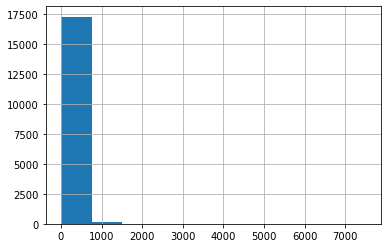

In [165]:
df_2019['price'].hist();

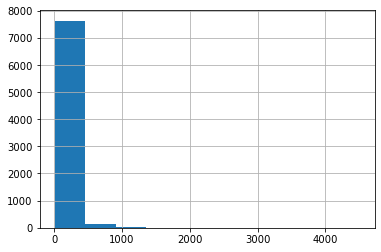

In [166]:
df_2020['price'].hist();

In [167]:
print(max(df_2019['price']))
print(max(df_2020['price']))

7500
4500


### There are some outliers for the price. In order to avoid underfitting or overfitting, we only keep the prive under 1000.
#### Remove:
* Price >= 1000
* minimum_nights >= 365


In [168]:
df_19 = df_2019[(df_2019['price']<=1000) & (df_2019['minimum_nights']<=365)]
df_20 = df_2020[(df_2020['price']<=1000) & (df_2020['minimum_nights']<=365)]

In [169]:
df_19['minimum_nights'].unique()

array([  1,   3,   2,   5,   4,   7,  29,  30,  20,  31,   6,   8,  45,
        28, 200,  14,  25,  35,  40,  44,  10,  90,  21,  19,  12, 115,
        15,   9,  60,  26,  18,  75, 120,  16,  13,  27,  22, 365, 180,
        11,  24,  59,  50, 130, 150, 135,  23,  80, 100, 300,  42,  56,
        32,  38, 210,  85,  89,  55,  62], dtype=int64)

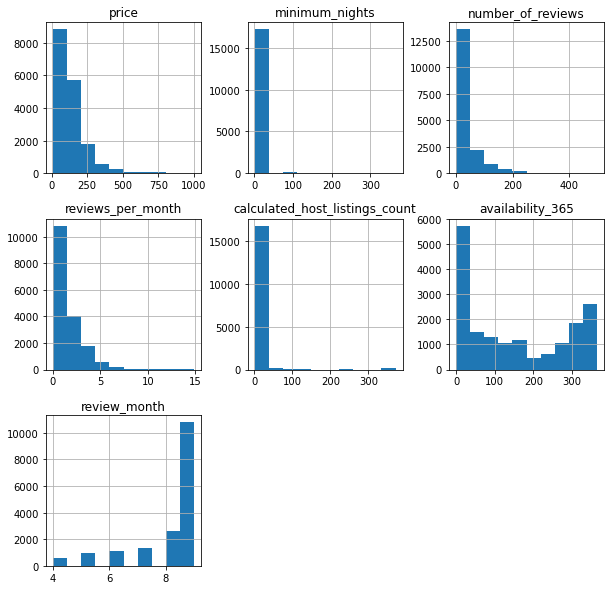

In [170]:
# Plotting the distribution
df_19.hist(figsize=(10,10));

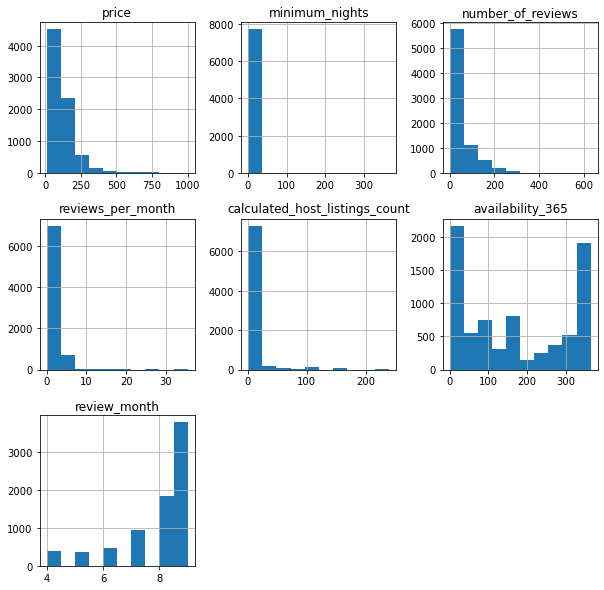

In [171]:
df_20.hist(figsize=(10,10));

In [172]:
#rename the review_month column values
df_19['review_month'] = df_19['review_month'].replace([4,5,6,7,8,9],['review_April','review_May','review_June','review_July','review_Aug','review_Sept'])
df_20['review_month'] = df_20['review_month'].replace([4,5,6,7,8,9],['review_April','review_May','review_June','review_July','review_Aug','review_Sept'])

C:\Users\yueli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\yueli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [173]:
df_19.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,17389.000000,17389.000000,17389.000000,17389.000000,17389.000000,17389.000000
mean,140.113290,6.504399,34.869170,1.526753,8.968313,148.374202
std,114.434572,12.847478,50.545903,1.414683,43.593601,134.197454
min,10.000000,1.000000,1.000000,0.020000,1.000000,0.000000
25%,68.000000,2.000000,5.000000,0.470000,1.000000,12.000000
50%,105.000000,2.000000,14.000000,1.030000,1.000000,114.000000
75%,175.000000,5.000000,43.000000,2.190000,3.000000,295.000000
max,1000.000000,365.000000,498.000000,14.850000,371.000000,365.000000


In [174]:
df_20.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000
mean,122.752061,8.427743,49.134853,1.677249,7.213292,168.203632
std,105.382405,15.115684,66.911832,1.589101,22.041097,139.825441
min,10.000000,1.000000,1.000000,0.030000,1.000000,0.000000
25%,59.000000,1.000000,5.000000,0.560000,1.000000,21.000000
50%,95.000000,3.000000,21.000000,1.195000,2.000000,155.000000
75%,150.000000,7.000000,67.000000,2.390000,4.000000,326.000000
max,1000.000000,365.000000,629.000000,35.450000,239.000000,365.000000


In [175]:
print("Median number of listings per host:", int(df_19.calculated_host_listings_count.median()))
print("Mean number of listings per host:", int(round(df_19.calculated_host_listings_count.mean())))
print(f"{int(round(100*len(df_19[df_19.calculated_host_listings_count == 1])/len(df_19)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 9
56% of listings are from hosts with one listing.


In [176]:
print("Median number of listings per host:", int(df_20.calculated_host_listings_count.median()))
print("Mean number of listings per host:", int(round(df_20.calculated_host_listings_count.mean())))
print(f"{int(round(100*len(df_20[df_20.calculated_host_listings_count == 1])/len(df_20)))}% of listings are from hosts with one listing.")

Median number of listings per host: 2
Mean number of listings per host: 7
47% of listings are from hosts with one listing.


### One-hot encoding
#### Convert all categorical variables into dummy variables

#### 1. Try convert all the neighbourhood into dummy variables (not just neighbourhood group) 
* There will be more than 200 neighbourhood area. If it doesn't work well, we can only use 5 neighbourhood groups

In [177]:
cleaned_df19 = pd.get_dummies(df_19)
cleaned_df20 = pd.get_dummies(df_20)

In [178]:
#There will be 229 columns in total
cleaned_df19
cleaned_df20

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_month_review_April,review_month_review_Aug,review_month_review_July,review_month_review_June,review_month_review_May,review_month_review_Sept
id,,,,,,,,,,,,,,,,,,,,,
3831,76,1,354,4.82,1,2,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
5803,82,4,181,1.30,3,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
7097,191,2,233,1.78,2,331,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
8490,120,2,116,0.86,2,352,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
9657,175,3,34,0.25,1,90,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45528663,52,1,1,1.00,4,85,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
45528803,55,1,1,1.00,4,85,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
45538046,68,1,2,2.00,1,352,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


#### 2. Try to delete neighbourhood columns and only convert neighbourhood groups into dummy variables

In [179]:
df19_Lneighbour = df_19.drop(['neighbourhood'],axis = 1) 
df20_Lneighbour = df_20.drop(['neighbourhood'],axis = 1) 

In [180]:
cleaned_df19_Lneighbour = pd.get_dummies(df19_Lneighbour)
cleaned_df20_Lneighbour = pd.get_dummies(df20_Lneighbour)

In [181]:
#There will be 21 columns in total
cleaned_df19_Lneighbour
cleaned_df20_Lneighbour

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_month_review_April,review_month_review_Aug,review_month_review_July,review_month_review_June,review_month_review_May,review_month_review_Sept
id,,,,,,,,,,,,,,,,,,,,,
3831,76,1,354,4.82,1,2,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
5803,82,4,181,1.30,3,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
7097,191,2,233,1.78,2,331,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
8490,120,2,116,0.86,2,352,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
9657,175,3,34,0.25,1,90,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45528663,52,1,1,1.00,4,85,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
45528803,55,1,1,1.00,4,85,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
45538046,68,1,2,2.00,1,352,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


### Correlation Matrix

In [182]:
corr19_1 = cleaned_df19.corr()
corr19_1

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_month_review_April,review_month_review_Aug,review_month_review_July,review_month_review_June,review_month_review_May,review_month_review_Sept
price,1.000000,-0.029719,-0.060626,-0.058962,0.134338,0.068369,-0.091390,-0.144662,0.296229,-0.162811,...,0.501277,0.055658,-0.479611,-0.117739,0.004528,0.005401,0.010234,-0.004561,-0.012010,-0.003415
minimum_nights,-0.029719,1.000000,-0.129396,-0.222163,0.062128,0.130458,-0.030321,-0.050696,0.085446,-0.031832,...,0.082416,-0.035321,-0.069308,-0.018172,0.038286,0.134894,0.067222,0.050642,0.049396,-0.198988
number_of_reviews,-0.060626,-0.129396,1.000000,0.554201,-0.083705,0.129485,-0.002984,0.020109,-0.023704,0.006115,...,-0.023931,-0.034010,0.038893,-0.022940,-0.074780,-0.128459,-0.100940,-0.088955,-0.088469,0.264128
reviews_per_month,-0.058962,-0.222163,0.554201,1.000000,-0.041387,0.062220,0.019943,-0.036980,-0.026718,0.079642,...,-0.083789,0.028570,0.069915,0.025405,-0.129931,-0.185834,-0.159188,-0.148361,-0.150088,0.417763
calculated_host_listings_count,0.134338,0.062128,-0.083705,-0.041387,1.000000,0.190925,-0.024640,-0.122024,0.155924,-0.033085,...,0.101150,0.013112,-0.100505,-0.013267,-0.006648,0.038763,0.011847,0.029566,0.000204,-0.047334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
review_month_review_Aug,0.005401,0.134894,-0.128459,-0.185834,0.038763,-0.035748,-0.012447,0.009856,0.013476,-0.028058,...,0.026886,-0.003044,-0.025747,-0.001976,-0.078892,1.000000,-0.121712,-0.107854,-0.100631,-0.535070
review_month_review_July,0.010234,0.067222,-0.100940,-0.159188,0.011847,-0.066455,-0.003725,0.006570,-0.004244,-0.003219,...,0.022208,0.004048,-0.017121,-0.019428,-0.055040,-0.121712,1.000000,-0.075246,-0.070207,-0.373299
review_month_review_June,-0.004561,0.050642,-0.088955,-0.148361,0.029566,-0.039347,0.004180,-0.001905,0.004695,-0.002690,...,-0.011132,0.005357,0.009200,0.002554,-0.048773,-0.107854,-0.075246,1.000000,-0.062213,-0.330797
review_month_review_May,-0.012010,0.049396,-0.088469,-0.150088,0.000204,-0.062825,-0.000404,0.007863,0.007602,-0.020301,...,-0.003087,-0.011059,0.010137,-0.014481,-0.045507,-0.100631,-0.070207,-0.062213,1.000000,-0.308643


In [183]:
corr19_2 = cleaned_df19_Lneighbour.corr()

In [184]:
cleaned_df19_Lneighbour.columns

Index(['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'review_month_review_April',
       'review_month_review_Aug', 'review_month_review_July',
       'review_month_review_June', 'review_month_review_May',
       'review_month_review_Sept'],
      dtype='object')

* 1. correlation matrix for cleaned_df19 dataset which includes all the neighbourhood areas \
In this case, the plot is terrible. It doesn't seem to have any correlation between different neighourhoods. I will only use another dataset to plot the correlation. 

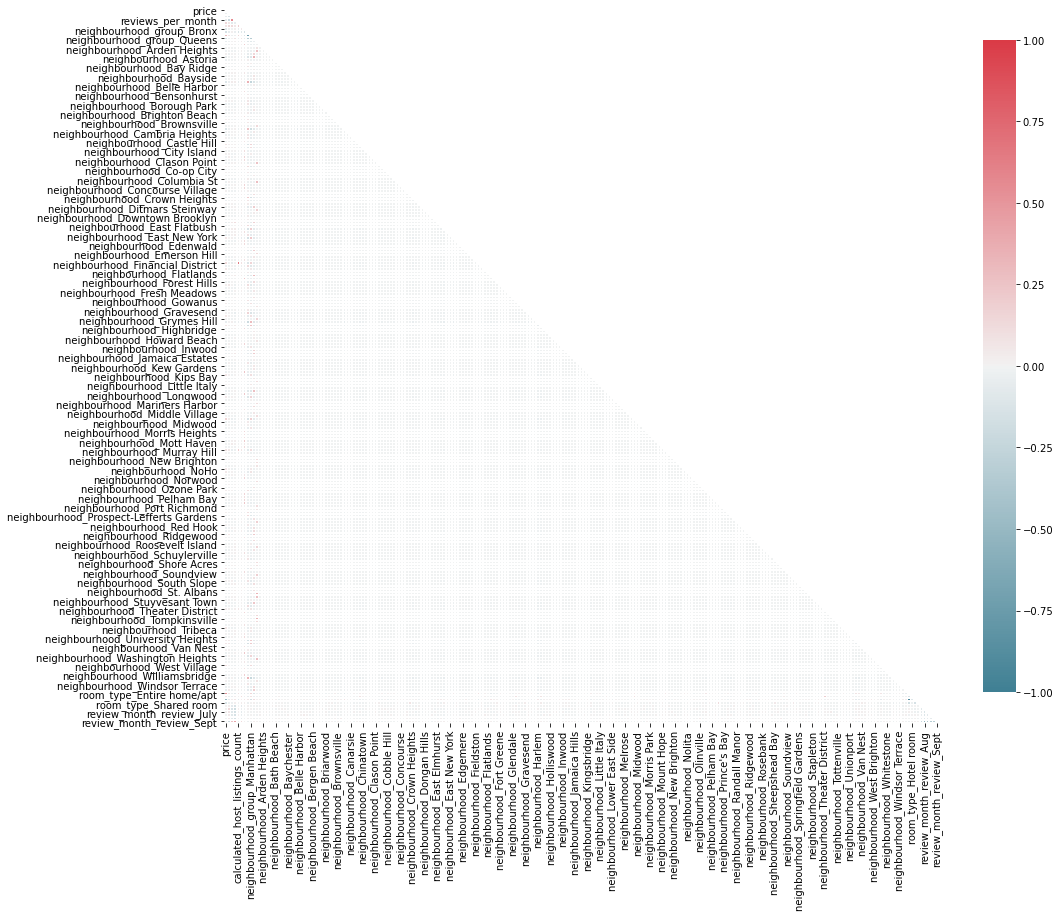

In [185]:
f, ax = plt.subplots(figsize=(16, 16))

mask = np.zeros_like(corr19_1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(
    corr19_1,          # The data to plot
    mask=mask,     # Mask upper-right cells
    cmap=cmap,    
    annot=False,    # don't plot values in the cells
    vmax=1,      
    vmin=-1,     
    center=0,      
    square=True,   # make square cells 
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .75}  # Extra kwargs for the legend; in this case, shrink to 75%
)


f.savefig('correlation matrix_heatmap.png')

* 2. correlation matrix for cleaned_df19_Lneighbour dataset which includes only 5 large neighbourhood groups

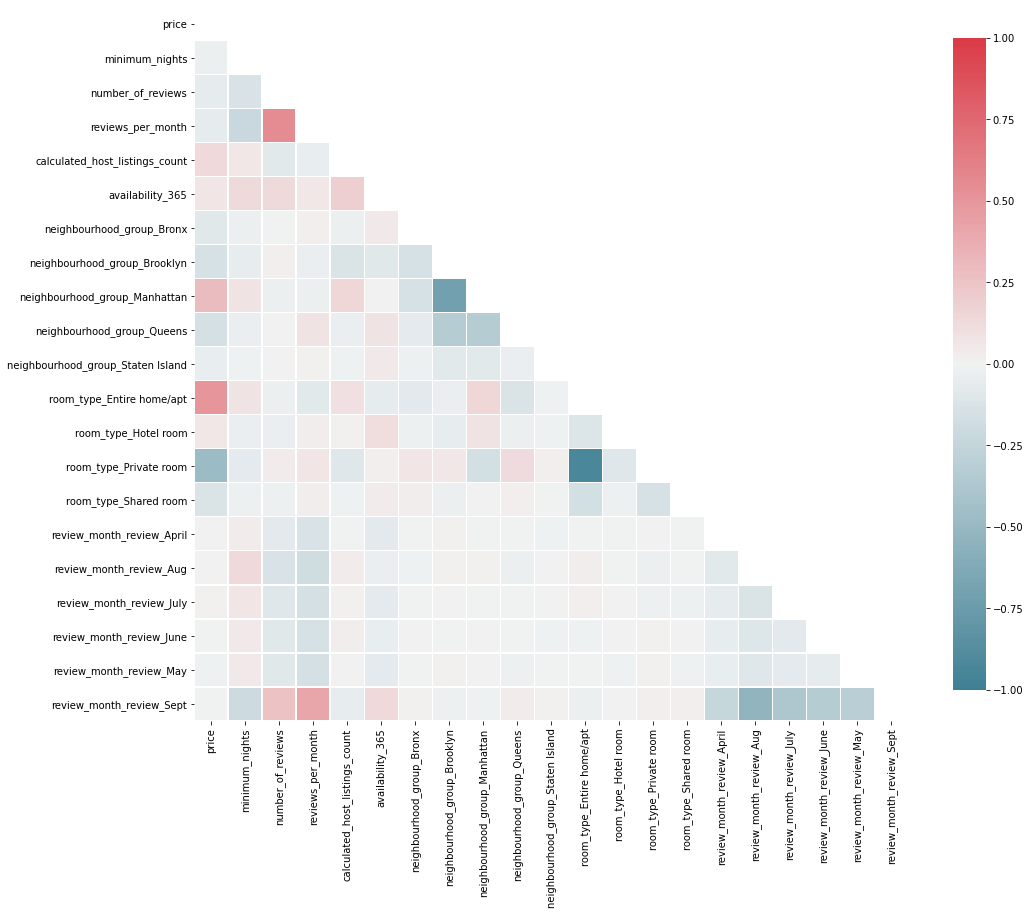

In [186]:
f, ax = plt.subplots(figsize=(16, 16))

mask = np.zeros_like(corr19_2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(
    corr19_2,          # The data to plot
    mask=mask,     # Mask upper-right cells
    cmap=cmap,    
    annot=False,    # don't plot values in the cells
    vmax=1,      
    vmin=-1,     
    center=0,      
    square=True,   # make square cells 
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .75}  # Extra kwargs for the legend; in this case, shrink to 75%
)


f.savefig('correlation matrix_heatmap.png')

* The number_of_reviews and reviews_per_month are highly correlated. So reviews_per_month will be deleted from the datasets.\
It will be done for both dataset.

In [187]:
cleaned_df19_Lneighbour = cleaned_df19_Lneighbour.drop(['reviews_per_month'],axis=1)
cleaned_df19 = cleaned_df19.drop(['reviews_per_month'],axis=1)

In [188]:
cleaned_df20_Lneighbour = cleaned_df20_Lneighbour.drop(['reviews_per_month'],axis=1)
cleaned_df20 = cleaned_df20.drop(['reviews_per_month'],axis=1)

### Build training and testing datasets

* 1. For the cleaned_df19, cleaned_df20 with specific neighbourhood area (200+ columns)

In [204]:
X19 = cleaned_df19.drop('price', axis=1)
y19 = cleaned_df19.price
# Scaling
#scaler = StandardScaler()
#X19 = pd.DataFrame(scaler.fit_transform(X19), columns=list(X19.columns))
# Randomly split into trainning and testing datasets 8:2
X_train19, X_test19, y_train19, y_test19 = train_test_split(X19, y19, test_size=0.2, random_state=123)

In [205]:
X20 = cleaned_df20.drop('price', axis=1)
y20 = cleaned_df20.price
# Scaling
#scaler = StandardScaler()
#X20 = pd.DataFrame(scaler.fit_transform(X20), columns=list(X20.columns))
# Randomly split into trainning and testing datasets 8:2
X_train20, X_test20, y_train20, y_test20 = train_test_split(X20, y20, test_size=0.2, random_state=123)

* 2. For the cleaned_df19_Lneighbour, cleaned_df20_Lneighbour with only large neighbourhood group

In [206]:
X19_L = cleaned_df19_Lneighbour.drop('price', axis=1)
y19_L = cleaned_df19_Lneighbour.price
# Scaling
#scaler = StandardScaler()
#X19_L = pd.DataFrame(scaler.fit_transform(X19_L), columns=list(X19_L.columns))
# Randomly split into trainning and testing datasets 8:2
X_train19_L, X_test19_L, y_train19_L, y_test19_L = train_test_split(X19_L, y19_L, test_size=0.2, random_state=123)

In [207]:
X20_L = cleaned_df20_Lneighbour.drop('price', axis=1)
y20_L = cleaned_df20_Lneighbour.price
# Scaling
#scaler = StandardScaler()
#X19_L = pd.DataFrame(scaler.fit_transform(X19_L), columns=list(X19_L.columns))
# Randomly split into trainning and testing datasets 8:2
X_train20_L, X_test20_L, y_train20_L, y_test20_L = train_test_split(X20_L, y20_L, test_size=0.2, random_state=123)

In [208]:
X_train19.to_excel('data/X_train19.xlsx')
y_train19.to_excel('data/y_train19.xlsx')
X_test19.to_excel('data/X_test19.xlsx')
y_test19.to_excel('data/y_test19.xlsx')

In [209]:
X_train20.to_excel('data/X_train20.xlsx')
y_train20.to_excel('data/y_train20.xlsx')
X_test20.to_excel('data/X_test20.xlsx')
y_test20.to_excel('data/y_test20.xlsx')

In [210]:
X_train19_L.to_excel('data/X_train19_L.xlsx')
y_train19_L.to_excel('data/y_train19_L.xlsx')
X_test19_L.to_excel('data/X_test19_L.xlsx')
y_test19_L.to_excel('data/y_test19_L.xlsx')

In [211]:
X_train20_L.to_excel('data/X_train20_L.xlsx')
y_train20_L.to_excel('data/y_train20_L.xlsx')
X_test20_L.to_excel('data/X_test20_L.xlsx')
y_test20_L.to_excel('data/y_test20_L.xlsx')

### Build XGBoost

In [212]:
xgb_reg_start = time.time()

xgb_reg1 = xgb.XGBRegressor()
xgb_reg1.fit(X_train19, y_train19)
training_preds_19 = xgb_reg1.predict(X_train19)
val_preds_19 = xgb_reg1.predict(X_test19)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train19, training_preds_19),4))
print("Validation MSE:", round(mean_squared_error(y_test19, val_preds_19),4))
print("\nTraining r2:", round(r2_score(y_train19, training_preds_19),4))
print("Validation r2:", round(r2_score(y_test19, val_preds_19),4))

Time taken to run: 0.1 minutes

Training MSE: 4288.4035
Validation MSE: 7369.8179

Training r2: 0.6716
Validation r2: 0.4434


In [225]:
xgb_reg_start = time.time()

xgb_reg3 = xgb.XGBRegressor()
xgb_reg3.fit(X_train19_L, y_train19_L)
training_preds_19_L = xgb_reg3.predict(X_train19_L)
val_preds_19_L = xgb_reg3.predict(X_test19_L)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train19_L, training_preds_19_L),4))
print("Validation MSE:", round(mean_squared_error(y_test19_L, val_preds_19_L),4))
print("\nTraining r2:", round(r2_score(y_train19_L, training_preds_19_L),4))
print("Validation r2:", round(r2_score(y_test19_L, val_preds_19_L),4))

Time taken to run: 0.0 minutes

Training MSE: 4361.2646
Validation MSE: 8832.7232

Training r2: 0.666
Validation r2: 0.3329


In [213]:
xgb_reg_start = time.time()

xgb_reg2 = xgb.XGBRegressor()
xgb_reg2.fit(X_train20, y_train20)
training_preds_20 = xgb_reg2.predict(X_train20)
val_preds_20 = xgb_reg2.predict(X_test20)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train20, training_preds_20),4))
print("Validation MSE:", round(mean_squared_error(y_test20, val_preds_20),4))
print("\nTraining r2:", round(r2_score(y_train20, training_preds_20),4))
print("Validation r2:", round(r2_score(y_test20, val_preds_20),4))

Time taken to run: 0.0 minutes

Training MSE: 3454.0962
Validation MSE: 7994.1118

Training r2: 0.6922
Validation r2: 0.2485


In [226]:
xgb_reg_start = time.time()

xgb_reg4 = xgb.XGBRegressor()
xgb_reg4.fit(X_train20_L, y_train20_L)
training_preds_20_L = xgb_reg4.predict(X_train20_L)
val_preds_20_L = xgb_reg4.predict(X_test20_L)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train20_L, training_preds_20_L),4))
print("Validation MSE:", round(mean_squared_error(y_test20_L, val_preds_20_L),4))
print("\nTraining r2:", round(r2_score(y_train20_L, training_preds_20_L),4))
print("Validation r2:", round(r2_score(y_test20_L, val_preds_20_L),4))

Time taken to run: 0.0 minutes

Training MSE: 2597.2801
Validation MSE: 9001.463

Training r2: 0.7685
Validation r2: 0.1539


In [216]:
ft_weights_xgb_reg19 = pd.DataFrame(xgb_reg1.feature_importances_, columns=['weight'], index=X_train19.columns)
ft_weights_xgb_reg19.sort_values('weight', inplace=True)
ft_weights_xgb_reg19

,weight
neighbourhood_Soundview,0.000000
neighbourhood_East Elmhurst,0.000000
neighbourhood_Lighthouse Hill,0.000000
neighbourhood_Little Neck,0.000000
neighbourhood_Douglaston,0.000000
...,...
neighbourhood_East Harlem,0.029795
neighbourhood_group_Brooklyn,0.030636
room_type_Hotel room,0.051308
room_type_Entire home/apt,0.092958


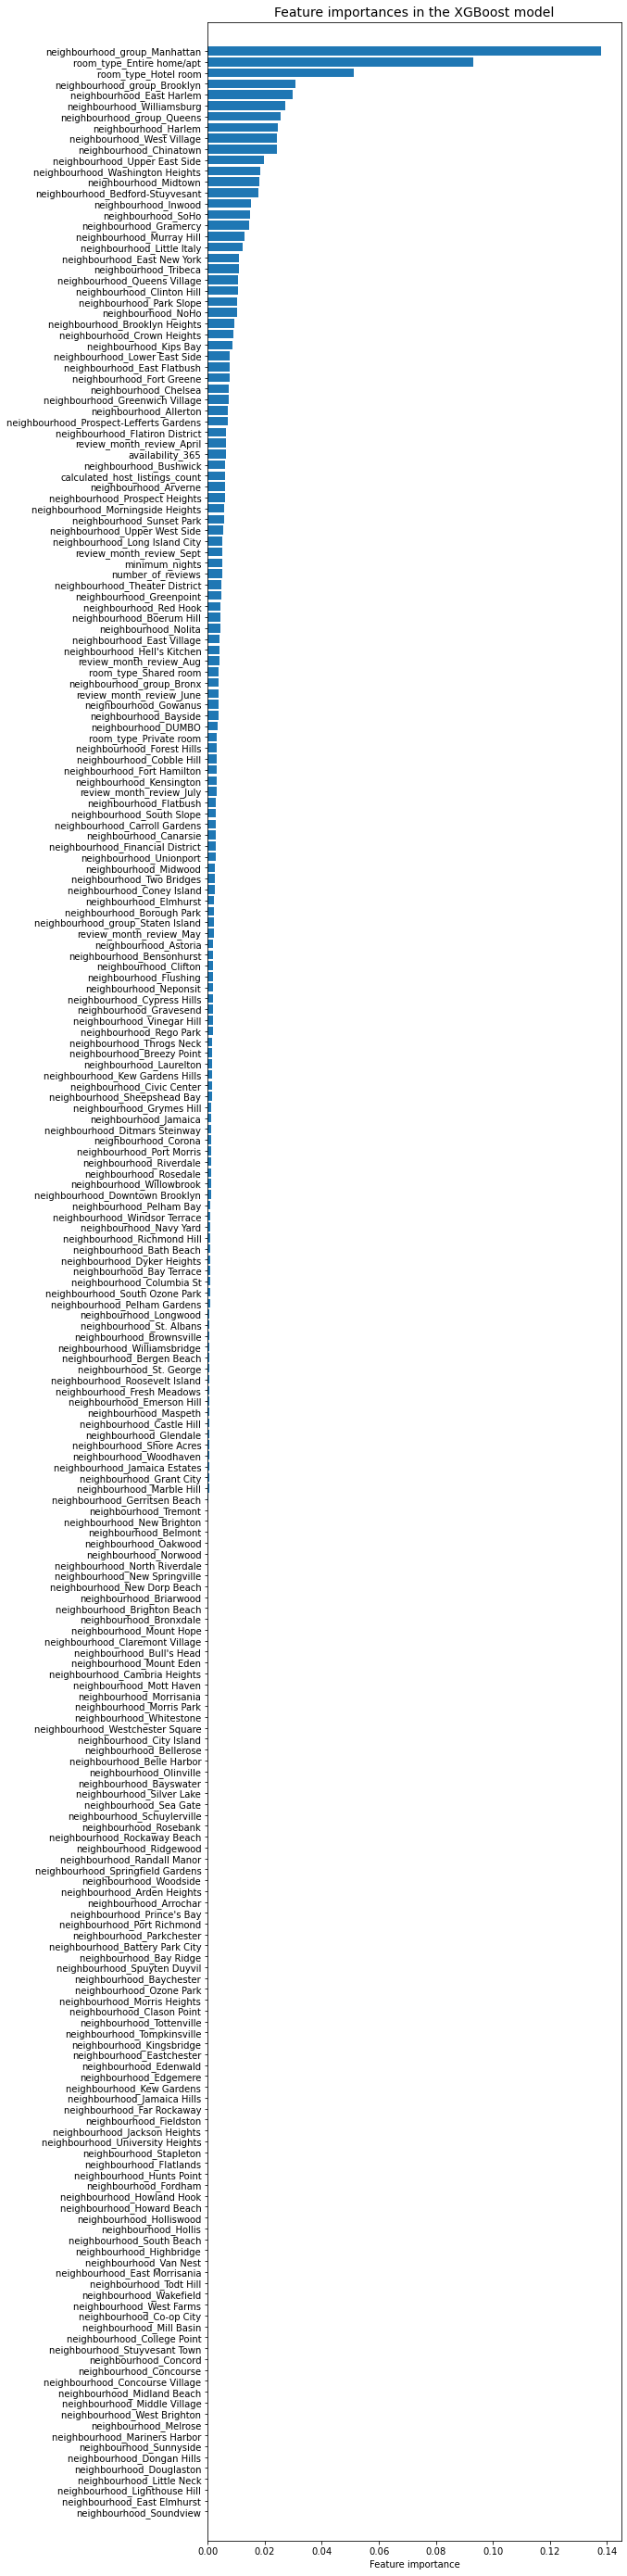

In [217]:
plt.figure(figsize=(8,50))
plt.barh(ft_weights_xgb_reg19.index, ft_weights_xgb_reg19.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [218]:
ft_weights_xgb_reg2 = pd.DataFrame(xgb_reg2.feature_importances_, columns=['weight'], index=X_train20.columns)
ft_weights_xgb_reg2.sort_values('weight', inplace=True)
ft_weights_xgb_reg2

,weight
neighbourhood_Fresh Meadows,0.000000
neighbourhood_Laurelton,0.000000
neighbourhood_Stapleton,0.000000
neighbourhood_Stuyvesant Town,0.000000
neighbourhood_Kew Gardens Hills,0.000000
...,...
neighbourhood_Harlem,0.031579
neighbourhood_SoHo,0.038678
neighbourhood_group_Manhattan,0.045010
room_type_Hotel room,0.063101


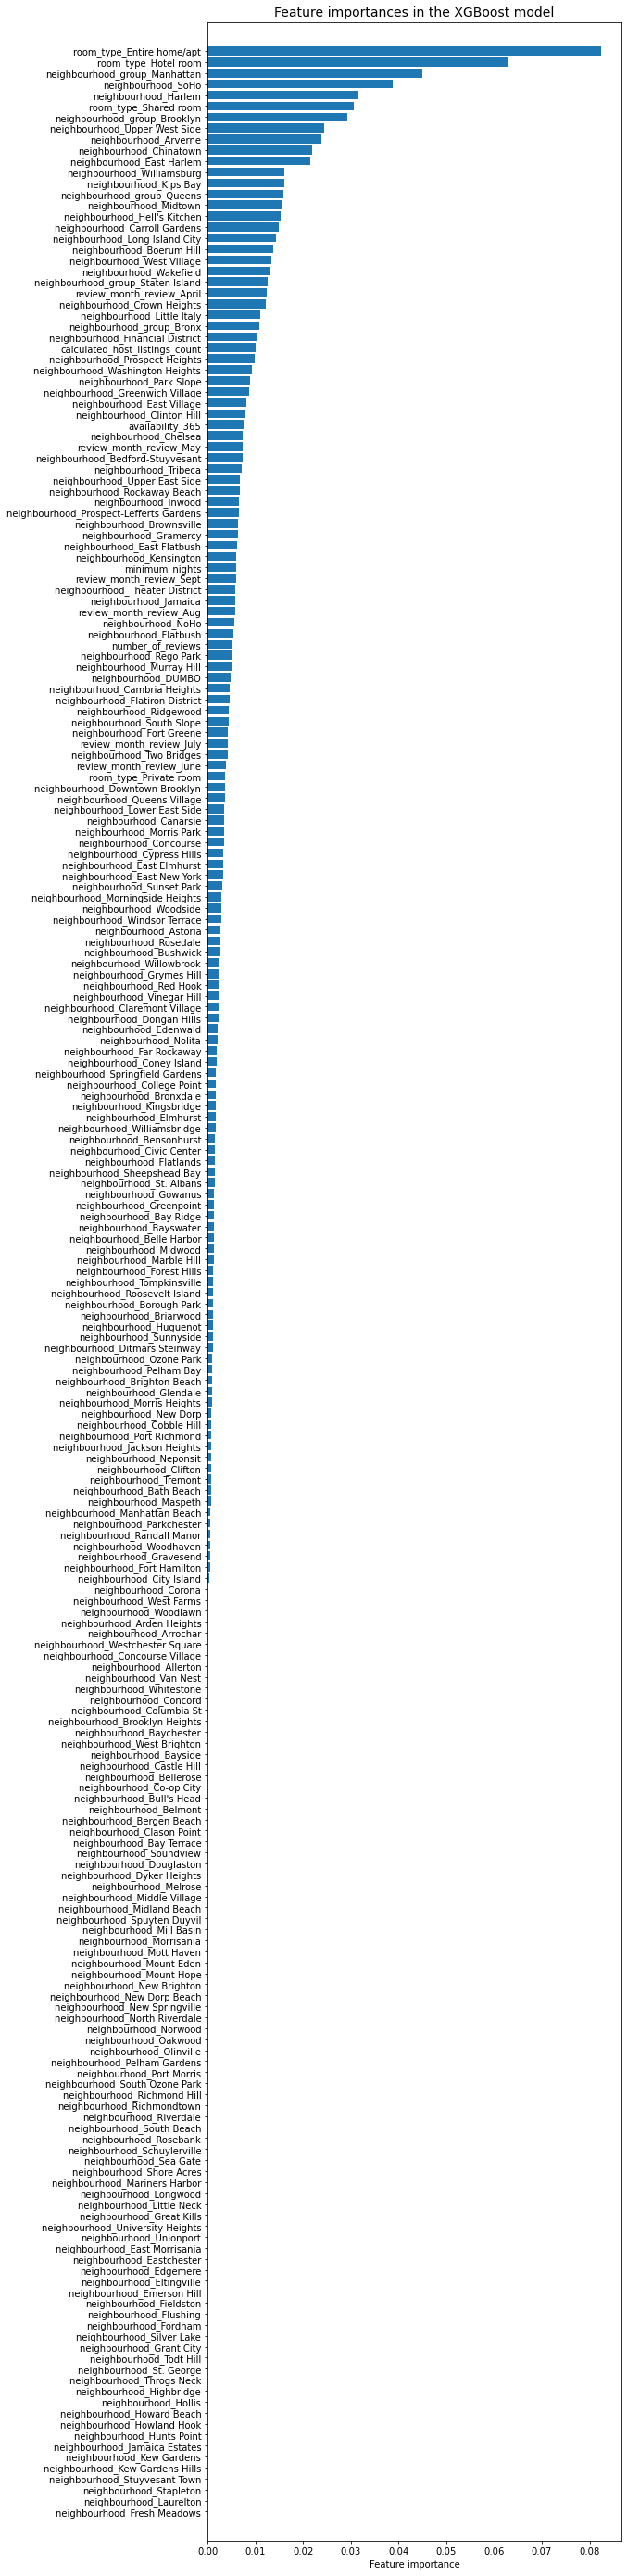

In [220]:
plt.figure(figsize=(8,50))
plt.barh(ft_weights_xgb_reg2.index, ft_weights_xgb_reg2.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [221]:
from sklearn.svm import SVR
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l1
from keras import optimizers

In [222]:
def print_evaluation_metrics(trained_model, trained_model_name, X_test, y_test):
    print('--------- For Model: ', trained_model_name, ' ---------\n')
    predicted_values = trained_model.predict(X_test)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_test, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_test, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_test, predicted_values))
    print("R2: ", metrics.r2_score(y_test, predicted_values))

def print_evaluation_metrics2(trained_model, trained_model_name, X_test, y_test):
    print('--------- For Model: ', trained_model_name, ' --------- (Train Data)\n')
    predicted_values = trained_model.predict(X_test)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_test, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_test, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_test, predicted_values))
    print("R2: ", metrics.r2_score(y_test, predicted_values))


In [111]:
def svm(X_train, y_train, X_val, y_val):
    model = SVR(gamma = 0.05, verbose = True) #was empty #0.1 #the - best gamma 0.05, c=0.5
    model.fit(X_train, y_train)
    print_evaluation_metrics(model, "svm", X_val, y_val.values.ravel())
    print_evaluation_metrics2(model, "svm", X_train, y_train.values.ravel())

In [223]:
svm(X_train19,y_train19, X_test19, y_test19)

[LibSVM]--------- For Model:  svm  ---------

Mean absolute error:  71.34457817590935
Median absolute error:  45.06941696903214
Mean squared error:  14337.351161323073
R2:  -0.08282891161183925
--------- For Model:  svm  --------- (Train Data)

Mean absolute error:  68.796999648957
Median absolute error:  42.655149163298816
Mean squared error:  13855.24506748641
R2:  -0.061173365907187804


In [224]:
svm(X_train20,y_train20, X_test20, y_test20)

[LibSVM]--------- For Model:  svm  ---------

Mean absolute error:  62.254038816921444
Median absolute error:  40.64304734006886
Mean squared error:  11322.257011972017
R2:  -0.064301581593319
--------- For Model:  svm  --------- (Train Data)

Mean absolute error:  61.42972882280901
Median absolute error:  40.8986074076993
Mean squared error:  11769.085128634775
R2:  -0.04889253566891272
